In [1]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree

# Para realizar la regresión lineal y la evaluación del modelo
# -----------------------------------------------------------------------
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error






# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree


# Para realizar la regresión lineal y la evaluación del modelo
# -----------------------------------------------------------------------
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


from sklearn.model_selection import KFold,LeaveOneOut, cross_val_score


from sklearn.preprocessing import StandardScaler

from tqdm import tqdm


# Ignorar los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')
import os 
import sys


sys.path.append(os.path.abspath("../src"))   
import soporte_regresion as f

In [2]:
df_encoded=pd.read_csv("..\datos\datos_nulos_encoded.csv", index_col=0)
df_encoded.reset_index(drop=True, inplace=True)

In [3]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360401 entries, 0 to 360400
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   price                360401 non-null  int64  
 1   vehicleType          360401 non-null  float64
 2   yearOfRegistration   360401 non-null  float64
 3   gearbox              360401 non-null  float64
 4   monthOfRegistration  360401 non-null  float64
 5   fuelType             360401 non-null  float64
 6   brand                360401 non-null  float64
 7   notRepairedDamage    360401 non-null  float64
 8   yearCreated          360401 non-null  float64
 9   monthCreated         360401 non-null  float64
 10  powerCV_robust       360401 non-null  float64
 11  kilometer_robust     360401 non-null  float64
 12  abtest_control       360401 non-null  float64
 13  abtest_test          360401 non-null  float64
dtypes: float64(13), int64(1)
memory usage: 38.5 MB


In [4]:
df_encoded.duplicated().sum()

np.int64(21086)

Separamos en x e y

In [5]:
x= df_encoded.drop(columns="price")
y= df_encoded[["price"]]

Separamos en train y test y le hacemos aprender

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size= 0.7, random_state=42)
modelo_lineal= LinearRegression()
modelo_lineal.fit(x_train, y_train) 

LinearRegression()

Ahora hacemos la predicción

In [7]:
y_test_pred=modelo_lineal.predict(x_test)         #con esto predice un precio
y_train_pred= modelo_lineal.predict(x_train)

***K-Fold***

In [8]:
f.metricas(y_train, y_train_pred, y_test, y_test_pred)

,train,test
r2_score,4.793891e-01,4.989145e-01
MAE,3.246366e+03,3.233012e+03
MSE,4.494529e+07,4.112651e+07
RMSE,6.704125e+03,6.412995e+03


In [9]:
kf= KFold(n_splits=5,
          shuffle=True,
          random_state=42)

score_r2= cross_val_score(modelo_lineal, x, y, cv=kf, scoring= "r2")
np.mean(score_r2)

np.float64(0.4851494000425993)

In [10]:
score_mae= cross_val_score(modelo_lineal, x, y, cv=kf, scoring= "neg_mean_absolute_error")
abs(np.mean(score_mae))

np.float64(3241.026943715624)

In [11]:
score_mse= cross_val_score(modelo_lineal, x, y, cv=kf, scoring= "neg_mean_squared_error")
abs(np.mean(score_mse))

np.float64(43810348.701288275)

In [12]:
score_rmse= cross_val_score(modelo_lineal, x, y, cv=kf, scoring= "neg_root_mean_squared_error")
abs(np.mean(score_rmse))

np.float64(6617.045131242284)

In [13]:
kf= KFold(n_splits=200,
          shuffle=True,
          random_state=42)

score_r2= cross_val_score(modelo_lineal, x, y, cv=kf, scoring= "r2")
np.mean(score_r2)

np.float64(0.5142140559675709)

In [14]:
score_rmse= cross_val_score(modelo_lineal, x, y, cv=kf, scoring= "neg_root_mean_squared_error")
abs(np.mean(score_rmse))

np.float64(6379.781786393451)

Cuantas más iteraciones más probabilidades de que seleccione el mismo paquete sobre el que aprender con lo que hay más riesgo de over fitting (porque es seleccion aleatoria)

**Como seleccionar que variables independientes eliminar si sucede over fitting**

In [15]:
pd.options.display.float_format = "{:,.2f}".format  #para quitar la notación cientifica
df_coefs=pd.DataFrame(modelo_lineal.coef_, columns= x.columns).T
df_coefs.sort_values(by=0, key= abs, ascending=False)    #para que ordene según la importancia

,0
kilometer_robust,"-3,234.82"
powerCV_robust,"2,936.09"
abtest_control,-16.45
abtest_test,16.45
yearCreated,0.85
fuelType,0.61
yearOfRegistration,0.57
brand,0.54
notRepairedDamage,0.44
monthOfRegistration,0.33


recursive_feature_elimination (PENDIENTE DE USO)

### Como me he dado cuenta de que no parece ser una relación lineal paso a decision tree

**DECISION TREE**  
Separa los datos en nodos y luego hace la media en el nodo final de la variable dependiente para los datos que se encuentran en ese nodo y cuando tenga que predecir, si el dato acaba en ese nodo, se le aplicará esa media como valor de su variable dependiente.  
   
***Para elegir el mejor árbol de decisión (conformado de unas variables independientes concretas)***   
Calcula la suma de los errores al cuadrado dividido entre n del nodo final de cada arbol y compara ese error y se queda con el que tenga el error mínimo
  
- Si hay mucha profundidad, los nodos finales van a ser tan específicos que se va a dar over fitting
  
***Como decirle que pare de dividir para evitar el Over Fitting***  
- max_depth (profundida máxima del árbol)
- min_sample_split (numero de datos minimo en el nodo (madre) para que se pueda dividir)  
- min_sample_leaf (numero de datos minimo que tienen que tener los nodos(hijos) en los que me divido) 
- max_leaf_nodes (numero maximo de nodos que quiero que tenga mi arbol)  
- max_features (numero máximo de variables independientes que queremos)

Pruebo primero a ver cómo me lo hace 

In [119]:
modelo_arbol_vacio= DecisionTreeRegressor()         
modelo_arbol_vacio.fit(x_train, y_train)
y_pred_test_arb_vacio= modelo_arbol_vacio.predict(x_test)
y_pred_train_arb_vacio= modelo_arbol_vacio.predict(x_train)
df_metricas_arbol_vacio= f.metricas(y_train, y_pred_train_arb_vacio, y_test, y_pred_test_arb_vacio)
df_metricas_arbol_vacio

,train,test
r2_score,0.98,0.47
MAE,376.03,"2,178.66"
MSE,"2,098,577.83","43,676,473.59"
RMSE,"1,448.65","6,608.82"


Dejándole a él sólo me da que se produce overfitting

In [17]:
# plot_tree(decision_tree=modelo_arbol, feature_names=x.columns, filled=True)

In [18]:
# Parámetros a evaluar
params_arbol = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [10, 50, 100, 200],
    'min_samples_leaf': [10, 50, 100, 200],
    'max_leaf_nodes': [4, 6, 8, 10, 20, 30]
}

grid_search_arbol=GridSearchCV(DecisionTreeRegressor(), param_grid=params_arbol, cv=5, scoring= "neg_mean_squared_error", n_jobs=-1)

grid_search_arbol.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10],
                         'max_leaf_nodes': [4, 6, 8, 10, 20, 30],
                         'min_samples_leaf': [10, 50, 100, 200],
                         'min_samples_split': [10, 50, 100, 200]},
             scoring='neg_mean_squared_error')

In [19]:
modelo_final_arbol=grid_search_arbol.best_estimator_  #para ver el mejor arbol que me ha elegido
modelo_final_arbol

DecisionTreeRegressor(max_depth=10, max_leaf_nodes=30, min_samples_leaf=10,
                      min_samples_split=10)

In [142]:
y_pred_test_arb= modelo_final_arbol.predict(x_test)
y_pred_train_arb= modelo_final_arbol.predict(x_train)
df_metricas_arbol= f.metricas(y_train, y_pred_train_arb, y_test, y_pred_test_arb)
df_metricas_arbol=df_metricas_arbol.T
df_metricas_arbol.reset_index(inplace=True)
df_metricas_arbol



,index,r2_score,MAE,MSE,RMSE
0,train,0.57,"2,894.44","36,810,709.74","6,067.18"
1,test,0.54,"2,899.87","37,449,608.19","6,119.61"


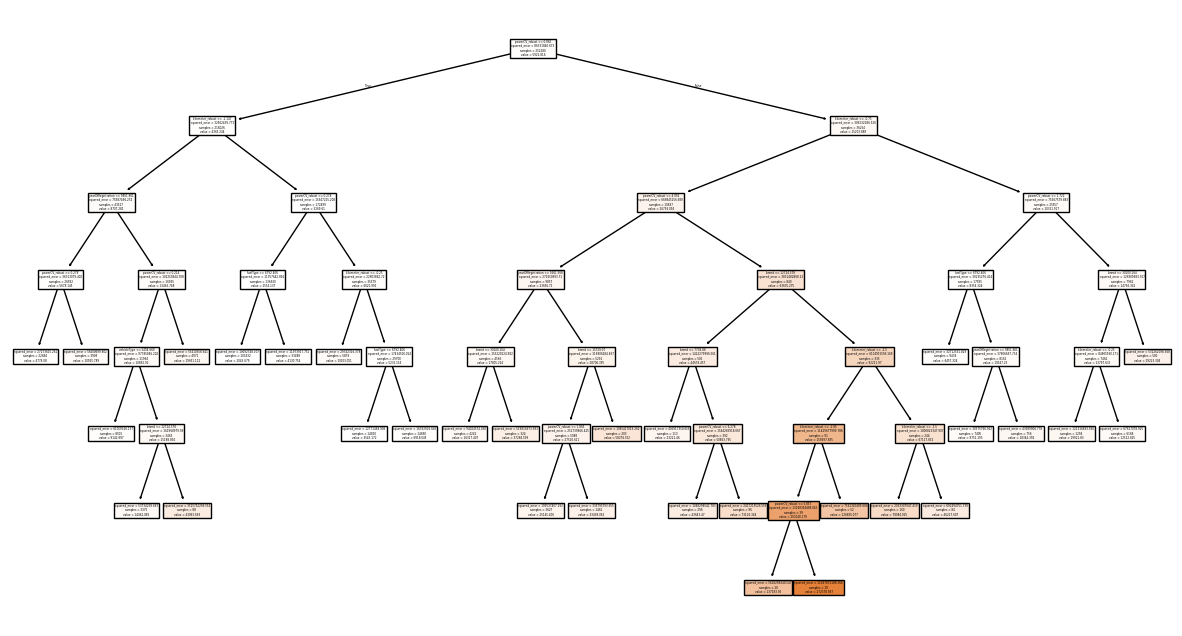

In [20]:
plt.figure(figsize=(15,8))
plot_tree(decision_tree=modelo_final_arbol, feature_names=x.columns, filled=True);

AHORA QUE SABEMOS QUE LA MEJOR DEPTH ES 10 ESTARÍA BIEN COMPARAR LA 10,11 Y 12 PARA VER SI SIGUE SIENDO LA MEJOR EL 10

### Vamos a graficarlo porque así se entienden mejor

In [21]:
df_resultados_arbol=pd.DataFrame(grid_search_arbol.cv_results_)

In [125]:
df_resultados_arbol.sort_values(by= "rank_test_score", ascending=True).head(2)    #aquí podemos ver cual nos ha dado como mejor modelo (el 1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
368,1.18,0.09,0.03,0.02,10,30,10,10,"{'max_depth': 10, 'max_leaf_nodes': 30, 'min_s...","-38,745,603.85","-41,444,764.51","-39,800,160.77","-32,902,742.60","-40,130,595.13","-38,604,773.37","2,978,443.25",1
272,0.98,0.05,0.02,0.00,7,30,10,10,"{'max_depth': 7, 'max_leaf_nodes': 30, 'min_sa...","-38,745,603.85","-41,444,764.51","-40,518,908.25","-32,902,742.60","-40,176,645.39","-38,757,732.92","3,053,399.70",2


In [23]:
df_resultados_arbol.shape   #no da el número de modelos que ha generado el árbol 

(384, 17)

In [24]:
df_resultados_arbol_filtrado=df_resultados_arbol.filter(like= "param").drop(columns= "params")
df_resultados_arbol_filtrado["MSE"]= df_resultados_arbol["mean_test_score"]
df_resultados_arbol_filtrado.head()


,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,MSE
0,3,4,10,10,"-58,921,360.76"
1,3,4,10,50,"-58,921,360.76"
2,3,4,10,100,"-58,921,360.76"
3,3,4,10,200,"-58,921,360.76"
4,3,4,50,10,"-58,921,360.76"


In [25]:
df_rmse_profun= np.sqrt(df_resultados_arbol_filtrado.groupby("param_max_depth")["MSE"].mean().abs()).reset_index()
df_rmse_profun.head()

,param_max_depth,MSE
0,3,"7,209.22"
1,5,"6,935.64"
2,7,"6,930.80"
3,10,"6,930.68"


## Estaría bien probarlo con el 11 y 12 para comprobar si consigo que siga bajando

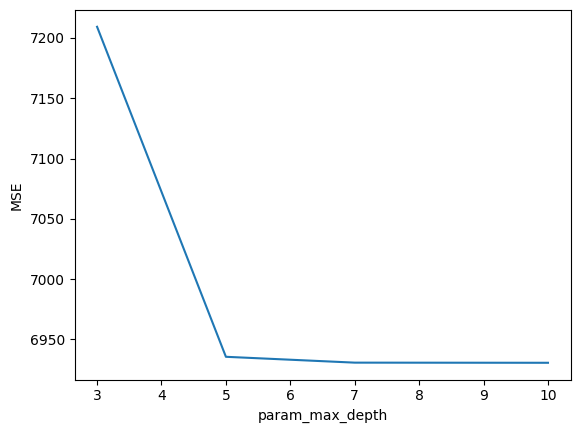

In [26]:
sns.lineplot(x= "param_max_depth", y = "MSE", data= df_rmse_profun);

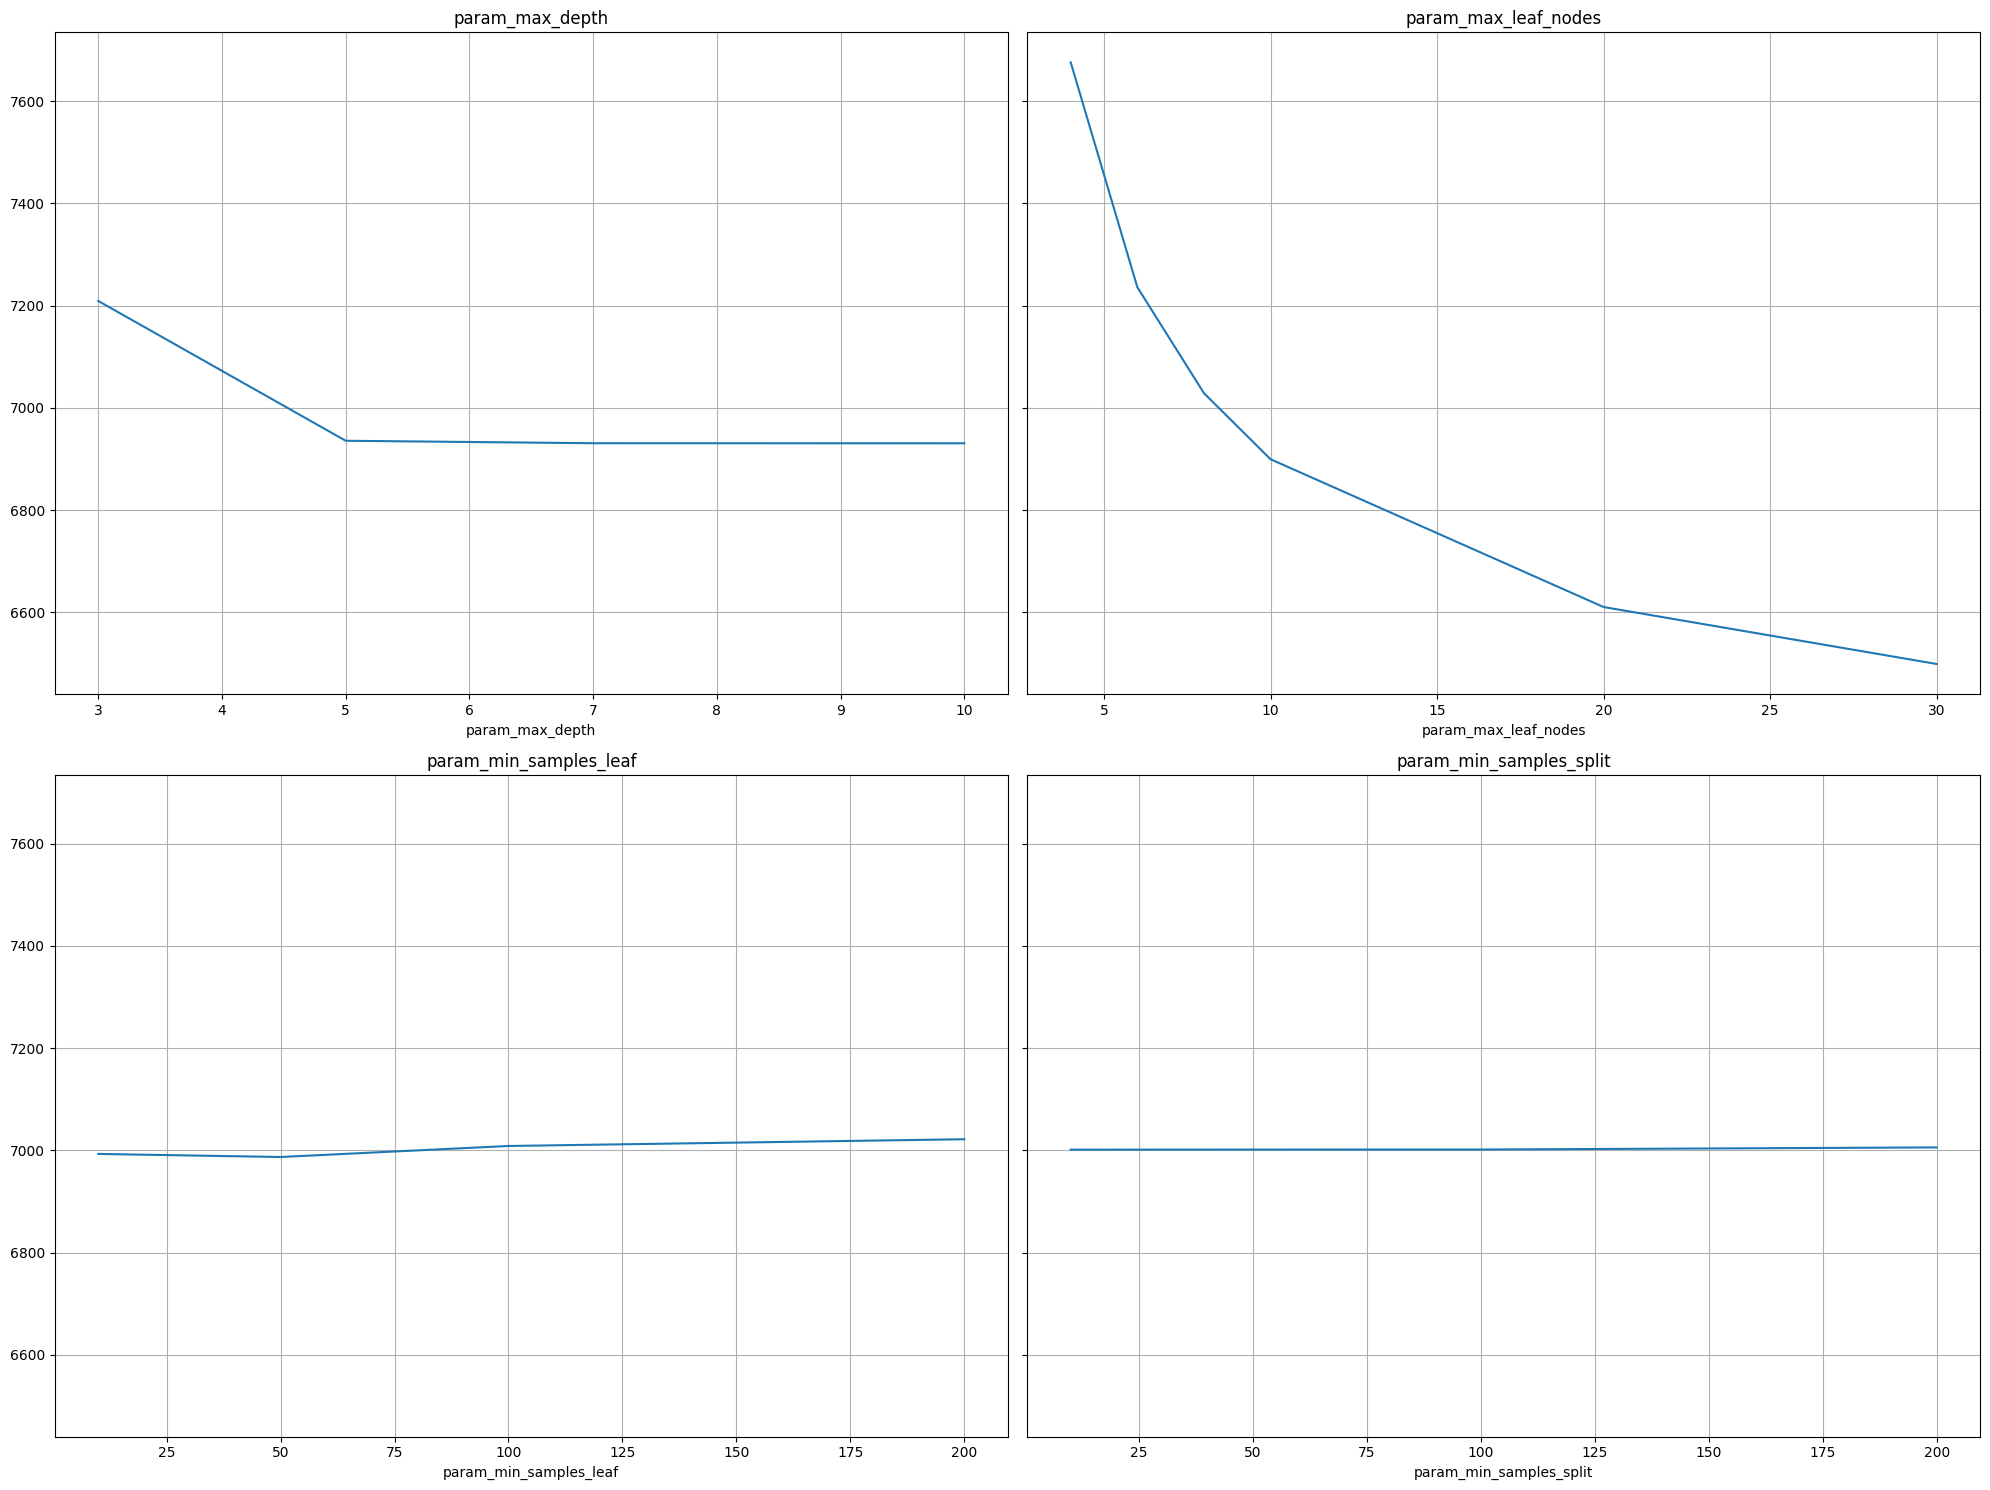

In [27]:

df_rmse_prof = np.sqrt(df_resultados_arbol_filtrado.groupby("param_max_depth")["MSE"].mean().abs())
df_rmse_prof = pd.DataFrame(df_rmse_prof).reset_index()

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 15), sharey=True)
axes = axes.flat

for indice, column in enumerate(df_resultados_arbol_filtrado.columns[:-1]):
    df_rmse_col = np.sqrt(df_resultados_arbol_filtrado.groupby(column)["MSE"].mean().abs())
    sns.lineplot(x=df_rmse_col.index, y=df_rmse_col.values, ax=axes[indice])
    axes[indice].grid()
    axes[indice].set_title(column)
plt.tight_layout()
plt.show() 

In [28]:
pd.DataFrame(modelo_final_arbol.feature_importances_, columns= ["Importancia"], index= x.columns).sort_values(by = "Importancia", ascending=False)

,Importancia
powerCV_robust,0.49
kilometer_robust,0.32
brand,0.08
yearOfRegistration,0.08
fuelType,0.02
vehicleType,0.01
gearbox,0.00
monthOfRegistration,0.00
notRepairedDamage,0.00
monthCreated,0.00


## Lo pruebo cambiando parametros

In [106]:
# Parámetros a evaluar
params_arbol_prueba = {
    'max_depth': [7,8, 60, 100, 200],
    'min_samples_split': [10, 50, 100, 200],
    'min_samples_leaf': [10, 50, 100, 200],
    'max_leaf_nodes': [4, 6, 8, 10, 20, 80]
}

grid_search_arbol_prueba=GridSearchCV(DecisionTreeRegressor(), param_grid=params_arbol_prueba , cv=5, scoring= "neg_mean_squared_error", n_jobs=-1)

grid_search_arbol_prueba.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [7, 8, 60, 100, 200],
                         'max_leaf_nodes': [4, 6, 8, 10, 20, 80],
                         'min_samples_leaf': [10, 50, 100, 200],
                         'min_samples_split': [10, 50, 100, 200]},
             scoring='neg_mean_squared_error')

In [107]:
modelo_final_arbol_prueba=grid_search_arbol_prueba.best_estimator_  #para ver el mejor arbol que me ha elegido
modelo_final_arbol_prueba

DecisionTreeRegressor(max_depth=8, max_leaf_nodes=80, min_samples_leaf=10,
                      min_samples_split=10)

In [140]:
y_pred_test_arb_prueba= modelo_final_arbol_prueba.predict(x_test)
y_pred_train_arb_prueba= modelo_final_arbol_prueba.predict(x_train)
df_metricas_arbol_prueba= f.metricas(y_train, y_pred_train_arb_prueba, y_test, y_pred_test_arb_prueba)

df_metricas_arbol_prueba=df_metricas_arbol_prueba.T
df_metricas_arbol_prueba.reset_index(inplace=True)
df_metricas_arbol_prueba

,index,r2_score,MAE,MSE,RMSE
0,train,0.64,"2,567.42","31,491,587.39","5,611.74"
1,test,0.60,"2,587.98","32,880,556.52","5,734.16"


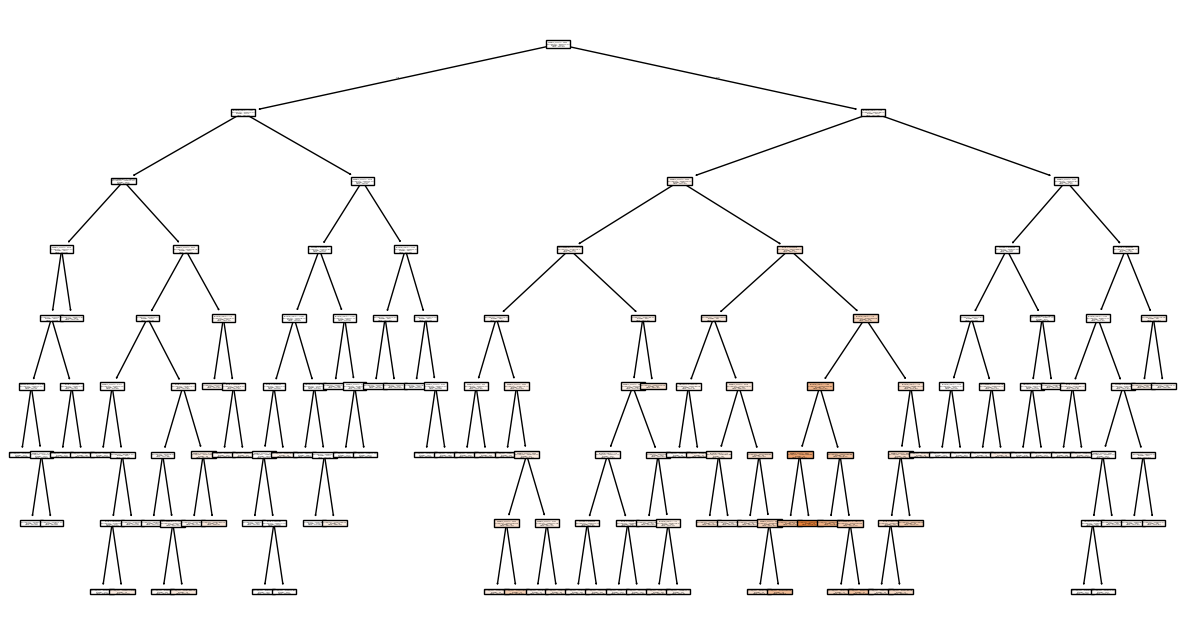

In [108]:
plt.figure(figsize=(15,8))
plot_tree(decision_tree=modelo_final_arbol_prueba, feature_names=x.columns, filled=True);

AHORA QUE SABEMOS QUE LA MEJOR DEPTH ES 8 ESTARÍA BIEN COMPARAR LA 10,11 Y 12 PARA VER SI SIGUE SIENDO LA MEJOR EL 10

### Vamos a graficarlo porque así se entienden mejor

In [109]:
df_resultados_arbol_prueba=pd.DataFrame(grid_search_arbol_prueba.cv_results_)

In [124]:
df_resultados_arbol_prueba.sort_values(by= "rank_test_score", ascending=True).head(2)    #aquí podemos ver cual nos ha dado como mejor modelo (el 1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
176,1.10,0.03,0.02,0.01,8,80,10,10,"{'max_depth': 8, 'max_leaf_nodes': 80, 'min_sa...","-34,282,022.17","-37,142,668.75","-36,751,478.81","-28,812,739.57","-36,684,373.47","-34,734,656.56","3,128,624.92",1
182,1.17,0.05,0.02,0.00,8,80,50,100,"{'max_depth': 8, 'max_leaf_nodes': 80, 'min_sa...","-33,837,136.20","-36,715,529.41","-37,685,176.21","-29,080,521.43","-36,640,105.10","-34,791,693.67","3,131,091.77",2


In [111]:
df_resultados_arbol_prueba.shape   #no da el número de modelos que ha generado el árbol 

(480, 17)

In [112]:
df_resultados_arbol_filtrado_prueba=df_resultados_arbol_prueba.filter(like= "param").drop(columns= "params")
df_resultados_arbol_filtrado_prueba["MSE"]= df_resultados_arbol_prueba["mean_test_score"]
df_resultados_arbol_filtrado_prueba.head()


,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,MSE
0,7,4,10,10,"-58,921,360.76"
1,7,4,10,50,"-58,921,360.76"
2,7,4,10,100,"-58,921,360.76"
3,7,4,10,200,"-58,921,360.76"
4,7,4,50,10,"-58,921,360.76"


In [113]:
df_rmse_profun_prueba= np.sqrt(df_resultados_arbol_filtrado_prueba.groupby("param_max_depth")["MSE"].mean().abs()).reset_index()
df_rmse_profun_prueba.head()

,param_max_depth,MSE
0,7,"6,889.71"
1,8,"6,887.07"
2,60,"6,887.80"
3,100,"6,887.80"
4,200,"6,887.80"


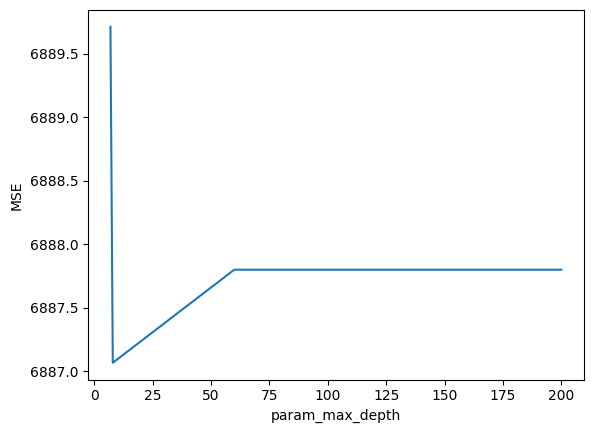

In [114]:
sns.lineplot(x= "param_max_depth", y = "MSE", data= df_rmse_profun_prueba);

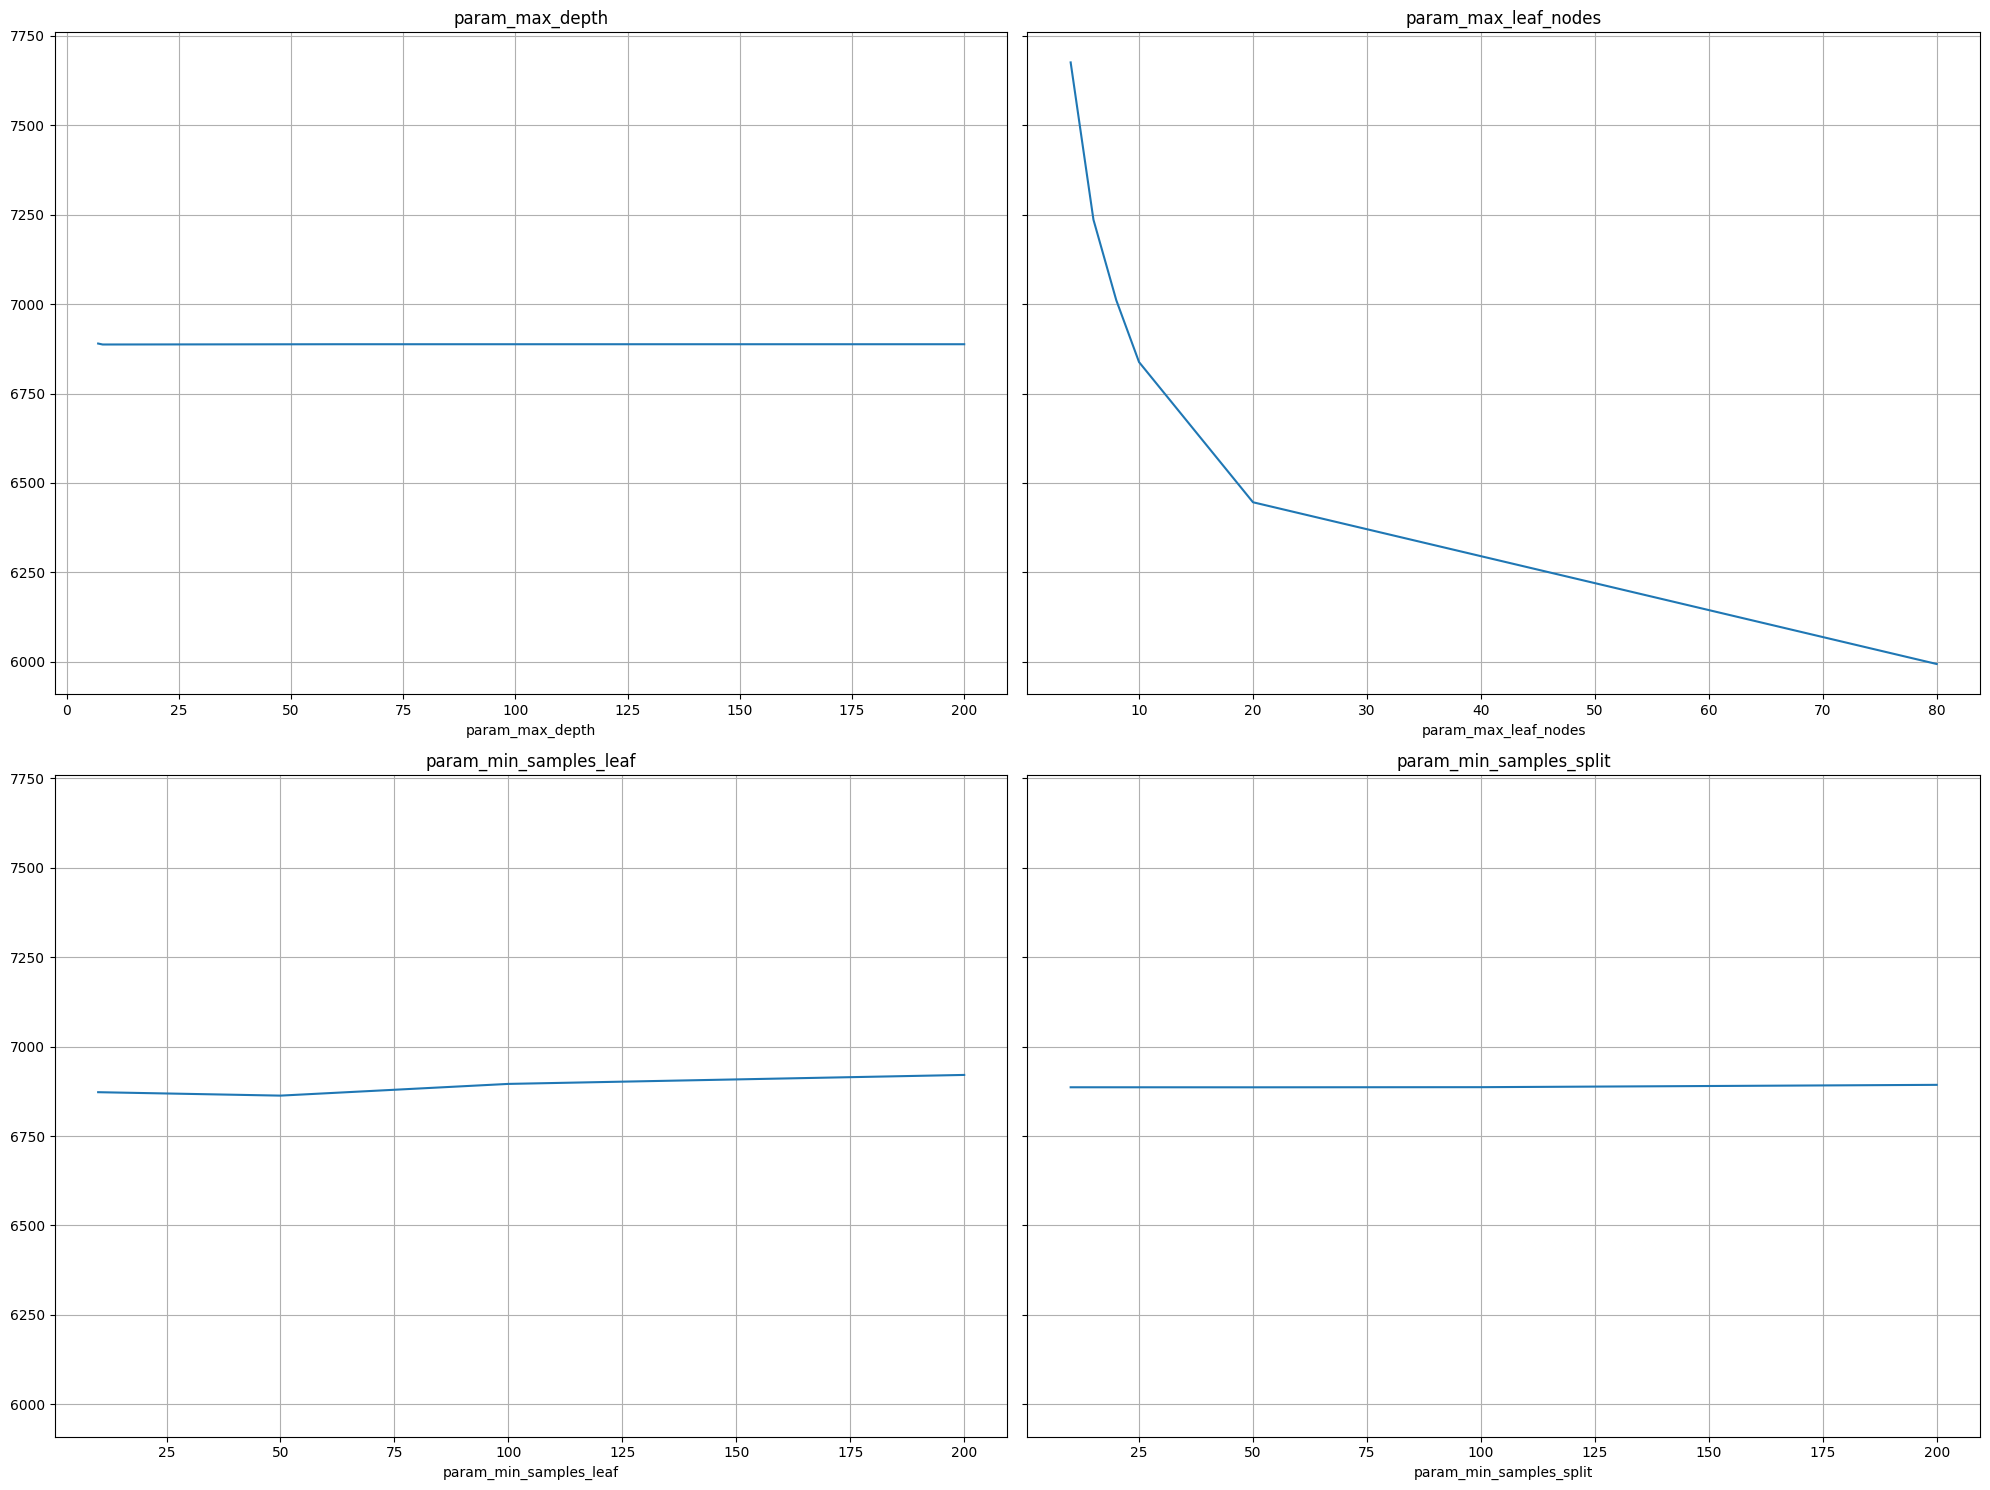

In [115]:

df_rmse_profun_prueba = np.sqrt(df_resultados_arbol_filtrado_prueba.groupby("param_max_depth")["MSE"].mean().abs())
df_rmse_profun_prueba = pd.DataFrame(df_rmse_profun_prueba).reset_index()

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 15), sharey=True)
axes = axes.flat

for indice, column in enumerate(df_resultados_arbol_filtrado_prueba.columns[:-1]):
    df_rmse_col_prueba = np.sqrt(df_resultados_arbol_filtrado_prueba.groupby(column)["MSE"].mean().abs())
    sns.lineplot(x=df_rmse_col_prueba.index, y=df_rmse_col_prueba.values, ax=axes[indice])
    axes[indice].grid()
    axes[indice].set_title(column)
plt.tight_layout()
plt.show() 

In [127]:
pd.DataFrame(modelo_final_arbol_prueba.feature_importances_, columns= ["Importancia"], index= x.columns).sort_values(by = "Importancia", ascending=False).head()

,Importancia
powerCV_robust,0.47
kilometer_robust,0.30
brand,0.09
yearOfRegistration,0.08
fuelType,0.03


De momento parece que mi segunda opción de parámetros me da los mejores resultados.

In [158]:
# Parámetros a evaluar
params_arbolu = {
    'max_depth': [7, 8, 200, 2000],
    'min_samples_split': [10, 50, 500, 2000],
    'min_samples_leaf': [10, 50, 500, 2000],
    'max_leaf_nodes': [4, 6, 8, 10, 100, 2000]
}

grid_search_arbolu=GridSearchCV(DecisionTreeRegressor(), param_grid=params_arbolu, cv=5, scoring= "neg_mean_squared_error", n_jobs=-1)

grid_search_arbolu.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [7, 8, 200, 2000],
                         'max_leaf_nodes': [4, 6, 8, 10, 100, 2000],
                         'min_samples_leaf': [10, 50, 500, 2000],
                         'min_samples_split': [10, 50, 500, 2000]},
             scoring='neg_mean_squared_error')

In [159]:
modelo_final_arbolu=grid_search_arbolu.best_estimator_  #para ver el mejor arbol que me ha elegido
modelo_final_arbolu

DecisionTreeRegressor(max_depth=200, max_leaf_nodes=2000, min_samples_leaf=10,
                      min_samples_split=50)

In [160]:
y_pred_test_arbu= modelo_final_arbolu.predict(x_test)
y_pred_train_arbu= modelo_final_arbolu.predict(x_train)
df_metricas_arbolu= f.metricas(y_train, y_pred_train_arbu, y_test, y_pred_test_arbu)
df_metricas_arbolu=df_metricas_arbolu.T
df_metricas_arbolu.reset_index(inplace=True)
df_metricas_arbolu

,index,r2_score,MAE,MSE,RMSE
0,train,0.72,"1,908.40","24,560,665.84","4,955.87"
1,test,0.67,"2,000.70","26,865,957.57","5,183.24"


In [161]:
dicc={0: "modelo1",
      1: "modelo1",
      2: "modelo2",
      3: "modelo2",
      4: "modelo3",
      5: "modelo3"}

In [162]:
df_final=pd.DataFrame()
df_final=pd.concat([df_final,df_metricas_arbolu, df_metricas_arbol_prueba,df_metricas_arbol], axis=0, ignore_index=True)
df_final.reset_index(inplace=True)
df_final["level_0"]=df_final["level_0"].map(dicc)
df_final

,level_0,index,r2_score,MAE,MSE,RMSE
0,modelo1,train,0.72,"1,908.40","24,560,665.84","4,955.87"
1,modelo1,test,0.67,"2,000.70","26,865,957.57","5,183.24"
2,modelo2,train,0.64,"2,567.42","31,491,587.39","5,611.74"
3,modelo2,test,0.60,"2,587.98","32,880,556.52","5,734.16"
4,modelo3,train,0.57,"2,894.44","36,810,709.74","6,067.18"
5,modelo3,test,0.54,"2,899.87","37,449,608.19","6,119.61"


## Finalmente me quedo con el modelo 1 correspondiente al 2000

In [167]:
df_metricas_arbolu.drop(columns= "index", inplace=True)

In [172]:
df_metricas_arbolua=df_metricas_arbolu.T
df_metricas_arbolua.columns= ["train", "test"]
df_metricas_arbolua.reset_index(inplace=True)
df_metricas_arbolua

,index,train,test
0,r2_score,0.72,0.67
1,MAE,"1,908.40","2,000.70"
2,MSE,"24,560,665.84","26,865,957.57"
3,RMSE,"4,955.87","5,183.24"


Vamos a intentar visualizar las cositas

In [173]:
predytest=pd.DataFrame(y_pred_test_arbu, columns=["y_pred_test_arbu"])

In [174]:
predytrain=pd.DataFrame(y_pred_train_arbu, columns=["y_pred_train_arbu"])

In [175]:
df_fin=pd.DataFrame()
df_fin=pd.concat([df_fin, predytest, predytrain, y], ignore_index=True, axis=1)

In [176]:
df_fin.columns= ["test_prediccion", "train_prediccion", "precio_original"]

In [177]:
df_fin.reset_index(inplace=True)

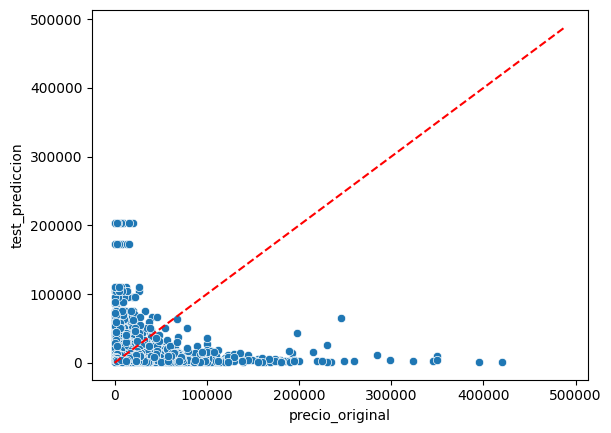

In [183]:
sns.scatterplot(x="precio_original", y="test_prediccion", data= df_fin)
plt.plot([df_fin["precio_original"].min(), df_fin["precio_original"].max()],
         [df_fin["precio_original"].min(), df_fin["precio_original"].max()],
         color='red', linestyle='--', label='x = y')

In [188]:
df_fino=df_fin[df_fin["precio_original"] <200000]

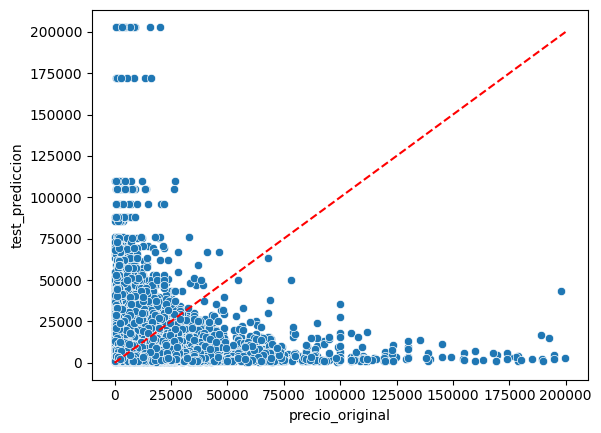

In [189]:
sns.scatterplot(x="precio_original", y="test_prediccion", data= df_fino)
plt.plot([df_fino["precio_original"].min(), df_fino["precio_original"].max()],
         [df_fino["precio_original"].min(), df_fino["precio_original"].max()],
         color='red', linestyle='--', label='x = y')

***CONCLUSIONES DE ESTE MODELO 1 PARA INTENTAR MEJORAR***  
  
- Este modelo 1 me predice mal los precios 0-30000 y 40000-5000000 (me predice los coches caros como baratos y viceversa)  
- Además más allá de 200000 no me predice nada.